In [1]:
import pandas as pd,statsmodels,sklearn,numpy,extractors,importlib
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots
import matplotlib.pyplot as plt
import datetime
importlib.reload(extractors)

downloadData=False
if (downloadData):
    stateLevelData=extractors.prepareData()
    borderStateDict=extractors.getBorderStates()
    stateLevelData.to_csv('us_states_covid_death_potential_covariates.csv',index=False)
else:
    stateLevelData=pd.read_csv('us_states_covid_death_potential_covariates.csv')
    borderStateDict=extractors.borderStatesCache


stateLevelDataNoDC=stateLevelData[stateLevelData["State/Territory"] != 'District of Columbia'].copy()

stateLevelDataNoDCNoAlaskaNoHawaii=stateLevelData[numpy.logical_and(stateLevelData['State/Territory'] != 'District of Columbia',
                                                numpy.logical_and(stateLevelData['State/Territory'] != 'Hawaii',
                                                        stateLevelData['State/Territory'] != 'Alaska'))].copy()



lower48=False
includeDC=False
if (lower48):
    stateLevelDataToUse=stateLevelDataNoDCNoAlaskaNoHawaii
elif (includeDC):
    stateLevelDataToUse=stateLevelData
else:
    stateLevelDataToUse=stateLevelDataNoDC
    
deathMetrics=['deaths_since_march1_2020_per330million',
               'deaths_since_oct1_2020_per330million',
               'pctExcessAfterMarch1_2020','pctExcessAfterOct1_2020']

deathMetricToFit='deaths_since_march1_2020_per330million'

#deathMetricToFit='deaths_since_oct1_2020_per330million'

#deathMetricToFit='pctExcessAfterMarch1_2020'

#deathMetricToFit='pctExcessAfterOct1_2020'

print('done')
showKeyCorrs=True
if (showKeyCorrs):
    print(stateLevelDataToUse[['deaths_since_march1_2020_per330million','gini_inequality','nursing_resid_per_pop',
                              'population_per_sq_mi','relative_humidity','stringency_index','Trump16McCain08Shift']].corr())

done
                                        deaths_since_march1_2020_per330million  \
deaths_since_march1_2020_per330million                                1.000000   
gini_inequality                                                       0.634191   
nursing_resid_per_pop                                                 0.476224   
population_per_sq_mi                                                  0.467373   
relative_humidity                                                    -0.051004   
stringency_index                                                     -0.176226   
Trump16McCain08Shift                                                  0.215536   

                                        gini_inequality  \
deaths_since_march1_2020_per330million         0.634191   
gini_inequality                                1.000000   
nursing_resid_per_pop                          0.168779   
population_per_sq_mi                           0.367097   
relative_humidity                          

In [2]:
def showTopCorrs(deathMetric,stateLevelDataToCorr,ascending,toShow=10):
    topCorrs=stateLevelDataToCorr.corr()[deathMetric].sort_values(ascending=ascending)
    shown=0
    for i in range(topCorrs.shape[0]):
        if (topCorrs.index[i].find('death')==-1):
            if (topCorrs.index[i].find('xcess')==-1):
                if (topCorrs.index[i].find('zeroMean')==-1):
                    if (topCorrs.index[i].find('stdized')==-1):
                        shown=shown+1
                        if (shown <= toShow):
                            print(topCorrs.index[i],"%3.3f"%(topCorrs[i]))

                    
for metric in deathMetrics:
    print('Top Positive Correlations with ' + metric + '\n')
    print('----------------------')
    showTopCorrs(metric,stateLevelDataToUse,ascending=False)
    print('Top Negative Correlations with ' + metric + '\n')
    print('----------------------')
    showTopCorrs(metric,stateLevelDataToUse,ascending=True)
    print('-----------------------\n\n')
    
    

Top Positive Correlations with deaths_since_march1_2020_per330million

----------------------
gini_inequality 0.634
nursing_resid_per_pop 0.476
population_per_sq_mi 0.467
afr_amer_pct 0.466
diabetes_pct 0.454
poverty_rate 0.400
urb_index_538 0.302
regular_church_pct 0.274
high_blood_pressure_pct 0.271
mean_temperature 0.250
Top Negative Correlations with deaths_since_march1_2020_per330million

----------------------
seldomornever_church_pct -0.395
cars_per_capita_pct -0.300
perc_pop_at_least_1_dose -0.210
stringency_index -0.176
perc_25plus_with_bachelors -0.124
res_per_household -0.099
dem_margin_2020 -0.068
relative_humidity -0.051
perc_blue_collar_jobs -0.047
under_18_pct -0.021
-----------------------


Top Positive Correlations with deaths_since_oct1_2020_per330million

----------------------
Trump16Share 0.493
nursing_resid_per_pop 0.490
obesity_rate 0.489
poverty_rate 0.463
diabetes_pct 0.444
Trump16McCain08Shift 0.400
regular_church_pct 0.396
cig_use_pct 0.393
Romney12Share 0.3

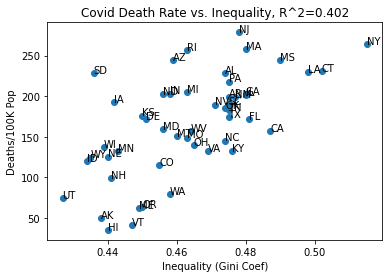

In [3]:
importlib.reload(extractors)

inEq='gini_inequality'

#inEq='nursing_resid_raw'

def doPlot(stateLevelDataToPlot,deathMetric,ylabel,title,removeDenseNortheast=False,removeSD=False):
    fig, ax = plt.subplots()
    if (removeSD):
        stateLevelDataToPlot=stateLevelDataToPlot[stateLevelDataToPlot["State/Territory"] != 'South Dakota']
    if (removeDenseNortheast):
        stateLevelDataToPlot=stateLevelDataToPlot[lambda df: numpy.logical_and(df["State/Territory"] != "New York",
                                                                               numpy.logical_and(df["State/Territory"] != "Massachusetts",
                                                                               numpy.logical_and(df["State/Territory"] != "Connecticut",
                                                                               numpy.logical_and(df["State/Territory"] != 'Rhode Island',
                                                                               df["State/Territory"] != "New Jersey")))) ]
    corr=stateLevelDataToPlot[[inEq,deathMetric]].corr()[inEq].values[1]
    R2=corr*corr
    ax.set_title(title + ', R^2=%3.3f'%R2)
    ax.set_xlabel('Inequality (Gini Coef)')
    ax.set_ylabel(ylabel)
    ax.scatter(stateLevelDataToPlot[inEq],stateLevelDataToPlot[deathMetric] )

    abbrs=[extractors.abbrevDict[v] for v in stateLevelDataToPlot['State/Territory'].values ]
    for i in range(stateLevelDataToPlot.shape[0]):
        ax.annotate(abbrs[i], (stateLevelDataToPlot[inEq].values[i], stateLevelDataToPlot[deathMetric].values[i]))
    fig.savefig(title.replace(' ','_') + '.png',format='png',bbox_inches='tight')

doPlot(stateLevelDataToUse,'deaths_since_march1_2020_per100k','Deaths/100K Pop','Covid Death Rate vs. Inequality')



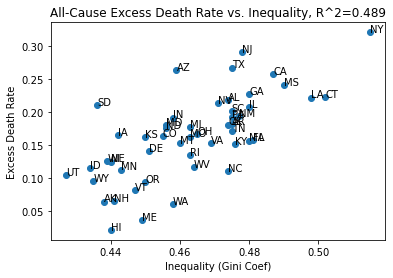

In [4]:
doPlot(stateLevelDataToUse,'pctExcessAfterMarch1_2020','Excess Death Rate','All-Cause Excess Death Rate vs. Inequality')

In [5]:
import sklearn
from sklearn import linear_model

allPotentialFeats=[]

for col in stateLevelDataToUse.columns:
    if (col=='abbr'):
        continue
    if (col=='State/Territory'):
        continue
    if (col=='population'):
        continue
    if (col.find('xcess')==-1):
        if (col.find('death')==-1):
            if ( (col.find('stdized') == -1) and (col.find('zeroMean')==-1) ):
                allPotentialFeats.append(col)
                
for col in allPotentialFeats:
        if ( not (col + '_stdized') in stateLevelDataNoDC.columns):
            stateLevelDataToUse[col + '_zeroMean']=stateLevelDataToUse[col]-stateLevelDataToUse[col].mean()
            stateLevelDataToUse[col + '_stdized']=stateLevelDataToUse[col + '_zeroMean']/stateLevelDataToUse[col + '_zeroMean'].std()

allPotentialFeats=[feat + '_stdized' for feat in allPotentialFeats]

print('number of potential features: %d'%(len(allPotentialFeats)))
print('all potential features:')
for feat in sorted(allPotentialFeats):
    print(feat)

number of potential features: 39
all potential features:
McCain08Share_stdized
Romney12Share_stdized
Trump16McCain08Shift_stdized
Trump16Share_stdized
afr_amer_pct_stdized
cars_per_capita_pct_stdized
cig_use_pct_stdized
dem_margin_2020_stdized
diabetes_pct_stdized
doctors_per_capita_stdized
gini_inequality_stdized
high_blood_pressure_pct_stdized
hispanic_latino_pct_stdized
income_per_capita_stdized
mean_temperature_stdized
median_age_stdized
mex_amer_pct_stdized
multi_gen_household_pct_stdized
nursing_resid_per_pop_stdized
obesity_rate_stdized
over_65_pct_stdized
pct_in_city_min_200k_stdized
perc_25plus_with_bachelors_stdized
perc_blue_collar_jobs_stdized
perc_pop_at_least_1_dose_stdized
perc_pop_nonwhite_stdized
perc_urban_stdized
population_per_sq_mi_stdized
poverty_rate_stdized
regular_church_pct_stdized
relative_humidity_stdized
res_per_household_stdized
seldomornever_church_pct_stdized
share_in_apts_pct_stdized
stringency_index_stdized
under_18_pct_stdized
undocumented_pct_stdized

In [6]:
numCrossValidationSplits=10

def lassoFeatureSelect(deathMetric,stateLevelDataToFit):
    print(stateLevelDataToFit.shape)
    targs=stateLevelDataToFit[deathMetric].values
    print('LASSO feature selection for %s\n\n'%deathMetric)
    bestAlpha=None
    bestAvgR2=0.
    
    tolLevel=0.001
    numpy.random.seed(1234)
    if (deathMetric.find('pctExcess') != -1):
        alphaRange=[1e-3,2e-3,3e-3,4e-3,5e-3,6e-3]
    else:
        alphaRange=[3e3,4e3,5e3,6e3,7e3,8e3,9e3,1e4]
    avgR2List=[]
    for alpha in alphaRange:
        colsToUse=allPotentialFeats
        feats=stateLevelDataToFit[colsToUse].values
        numTrials=500
        r2List=[]
        for j in range(numTrials):
            rNums=numpy.random.permutation(targs.shape[0])
            rNums=numpy.mod(rNums,numCrossValidationSplits)
            allValPreds=numpy.zeros(targs.shape[0])
            for i in range(numCrossValidationSplits):
                train=numpy.where(rNums != i)
                val=numpy.where(rNums==i)
                lassoModel=sklearn.linear_model.Lasso(alpha=alpha,max_iter=10000,tol=tolLevel)
                lassoModel.fit(feats[train],targs[train])
                valPreds=lassoModel.predict(feats[val])
                allValPreds[val[0]]=valPreds
            r2List.append(sklearn.metrics.r2_score(targs,allValPreds))
        print('avg r2 with for alpha=%4.4f:'%alpha)
        avgR2=numpy.mean(r2List)
        avgR2List.append(avgR2)
        print("%3.3f"%(avgR2))
        if (avgR2 > bestAvgR2):
            bestAvgR2=avgR2
            bestAlpha=alpha

    if (numpy.max(avgR2List)==avgR2List[0]):
        raise Exception('best R2 for alpha=%4.4f, alpha range should be decreased'%alphaRange[0])
    if (numpy.max(avgR2List)==avgR2List[-1]):
        raise Exception('best R2 for alpha=%4.4f, alpha range should be increased'%alphaRange[-1])
    print('bestAlpha: %3.3f'%bestAlpha)
    lassoModel=sklearn.linear_model.Lasso(alpha=bestAlpha,tol=tolLevel)
    lassoModel.fit(feats,targs)

    absCoef=numpy.array([numpy.abs(lassoModel.coef_[i]) for i in range(len(lassoModel.coef_))])

    argsort=numpy.argsort(-absCoef)

    coefSorted=lassoModel.coef_[argsort]
    featsSorted=numpy.array(allPotentialFeats)[argsort]

    for i in range(len(lassoModel.coef_)):
        print(featsSorted[i],"%4.4f"%(coefSorted[i]))
    print('----------------------------------------\n\n')  

doLasso=False
if (doLasso):
    for dMetric in deathMetrics:
        lassoFeatureSelect(dMetric,stateLevelDataToUse)

In [7]:
splitGiniIntoIncomeAndPoverty=False

if (deathMetricToFit=='deaths_since_march1_2020_per330million'):
        #save this
        if (splitGiniIntoIncomeAndPoverty==False):
            modelString=deathMetricToFit + '~' + '+'.join(
            ['stringency_index_stdized', 
            'relative_humidity_stdized', 
            'nursing_resid_per_pop_stdized', 
            'gini_inequality_stdized',
            'population_per_sq_mi_stdized'
             ] )
        else:
            modelString=deathMetricToFit + '~' + '+'.join(
          ['stringency_index_stdized', 
        'relative_humidity_stdized', 
        'nursing_resid_per_pop_stdized', 
        'poverty_rate_stdized',
           'income_per_capita_stdized',
         'population_per_sq_mi_stdized'
         ] )           
elif (deathMetricToFit=='deaths_since_oct1_2020_per330million'):
        #save this
        
        #nursing and Trump shift both? That is the question
        modelString=deathMetricToFit + '~' + '+'.join(
        [ 'stringency_index_stdized', 
        'relative_humidity_stdized', 
        'Trump16McCain08Shift_stdized', 
        'gini_inequality_stdized'
        ] ) #2902.1670   
elif (deathMetricToFit=='pctExcessAfterMarch1_2020'):
        modelString=deathMetricToFit + '~' +'+'.join([
            'gini_inequality_stdized', 
            'stringency_index_stdized',
            'relative_humidity_stdized',  
            'population_per_sq_mi_stdized', 
            ])                                                
elif (deathMetricToFit=='pctExcessAfterOct1_2020'):   
    modelString=deathMetricToFit + '~' + '+'.join([
    'stringency_index_stdized',
    'gini_inequality_stdized', 
    'relative_humidity_stdized',
   'Trump16McCain08Shift_stdized',
        'under_18_pct_stdized'
    ]) 
                                       
per100k=False
     
if (per100k):
    modelString=modelString.replace('deaths_per_330million','deaths_per_100k')
    
modelString=modelString.replace('~+','~')
print('Fitting this model:\n')
print(modelString+ '\n')
results = smf.ols(modelString,data=stateLevelDataToUse).fit()
results_robust = results.get_robustcov_results()
robustSE=True
if (robustSE):
    print(str(results_robust.summary()))
else:
    print(results.summary())

Fitting this model:

deaths_since_march1_2020_per330million~stringency_index_stdized+relative_humidity_stdized+nursing_resid_per_pop_stdized+gini_inequality_stdized+population_per_sq_mi_stdized

                                      OLS Regression Results                                      
Dep. Variable:     deaths_since_march1_2020_per330million   R-squared:                       0.786
Model:                                                OLS   Adj. R-squared:                  0.762
Method:                                     Least Squares   F-statistic:                     47.82
Date:                                    Fri, 18 Jun 2021   Prob (F-statistic):           1.08e-16
Time:                                            11:50:21   Log-Likelihood:                -642.68
No. Observations:                                      50   AIC:                             1297.
Df Residuals:                                          44   BIC:                             1309.
Df Model:    

In [8]:
stateLevelDataToUse['Residuals']=results.resid
stateLevelDataToUse['FittedValues']=results.fittedvalues

import statsmodels.stats.diagnostic
print(statsmodels.stats.diagnostic.anderson_statistic(results.resid))

0.21318431763170054


In [9]:
print('properly population-weighted total national prediction')
print(numpy.dot(stateLevelDataToUse['FittedValues'],stateLevelDataToUse['population'])/3.3e8)

properly population-weighted total national prediction
596628.5399742313


In [10]:
print(stateLevelDataToUse.sort_values('Residuals')[['State/Territory',deathMetricToFit,'FittedValues','Residuals']])

   State/Territory  deaths_since_march1_2020_per330million   FittedValues  \
44            Utah                           245084.308653  418552.440070   
25        Missouri                           491497.415530  662532.780653   
35            Ohio                           462261.423035  606135.294826   
29   New Hampshire                           328856.646743  472095.694618   
6      Connecticut                           763428.021363  899137.756846   
45         Vermont                           135387.002014  264520.871010   
5         Colorado                           380442.861072  491181.696012   
36        Oklahoma                           610800.534045  721014.765546   
17        Kentucky                           435501.882076  536455.325097   
4       California                           517998.190079  611615.020035   
9          Florida                           568080.799202  657852.420152   
19           Maine                           206953.962619  278701.920029   

C:\Users\joe_s\Anaconda3\envs\renv\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
C:\Users\joe_s\Anaconda3\envs\renv\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


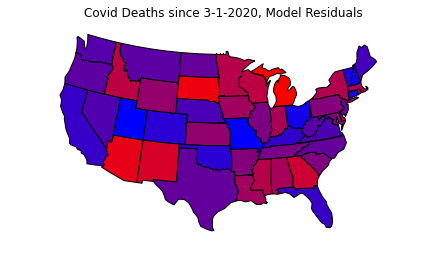

In [11]:

residDict=dict(zip(stateLevelDataToUse['State/Territory'].values,stateLevelDataToUse['Residuals'].values))
def plotMap(stateVals,title):
    maxVal=numpy.max([v for v in stateVals.values()])
    minVal=numpy.min([v for v in stateVals.values()])
    span=maxVal-minVal
    import cartopy.crs as ccrs
    import cartopy.io.shapereader as shpreader

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())

    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    ax.set_title(title)

    for state in shpreader.Reader(states_shp).records():
        if (state.attributes['name']=='District of Columbia'):
            continue
        if (lower48 and state.attributes['name']=='Hawaii'):
            continue
        if (lower48 and state.attributes['name']=='Alaska'):
            continue
    ### I need to replace the following code with code that sets the
    ### facecolor as a gradient based on the population density above
    #facecolor = [0.9375, 0.9375, 0.859375]
    
        state_val=stateVals[ state.attributes['name'] ]
        facecolor=[(state_val-minVal)/span,0.,1 - (state_val-minVal)/span]
    
        edgecolor = 'black'

        ax.add_geometries([state.geometry], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor)
    fig.savefig(title.replace(' ','_') + '.png',format='png',bbox_inches='tight')

    plt.show()
title=''
if (deathMetricToFit=='deaths_since_march1_2020_per330million'):
    title='Covid Deaths since 3-1-2020, Model Residuals'
elif (deathMetricToFit=='deaths_since_oct1_2020_per330million'):
    title='Covid Deaths since 10-1-2020, Model Residuals'
elif (deathMetricToFit=='pctExcessAfterMarch1_2020'):
    title='Excess Death Pct since 3-1-2020, Model Residuals'
elif(deathMetricToFit=='pctExcessAfterOct1_2020'):
    title='Excess Death Pct since 10-1-2020, Model Residuals'

plotMap(residDict,title) 

In [12]:
resids=[]
meanBorderStateResids=[]
statesWithBorderingStates=[]

for state in residDict:
    if (borderStateDict[state][0] !='None' ):
        statesWithBorderingStates.append(state)
        resids.append(residDict[state])
        meanBorderStateResids.append(numpy.mean([residDict[borderState.strip()] for borderState in borderStateDict[state] ]))
        
print('correlation of residual with residuals of bordering states:')                         
print(numpy.corrcoef(resids,meanBorderStateResids)[0][1])

correlation of residual with residuals of bordering states:
-0.041423925522290954


In [13]:
def skipEmpty(strList):
    filt=[]
    for strng in strList:
        if (strng.strip() !=''):
            filt.append(strng)
    return filt


def getSigs(numCoef,robust=True):
    if (robust):
        tb=str(results_robust.summary().tables[1])
    else:
        tb=str(results.summary().tables[1])
    lines=tb.split('\n')[3:3+numCoef+1]
  
    dct=dict()
    def getSig(line):
        return float(skipEmpty(line.strip().split(' '))[4].strip())
        
    def getCoefName(line):
        return line.strip().split(' ')[0].strip()
    
    dct['Intercept']=getSig(lines[0])
   
    for i in range(1,numCoef+1):
        dct[getCoefName(lines[i])]=getSig(lines[i])
    return dct

def getCoefs(numCoef):
    tb=str(results_robust.summary().tables[1])
    lines=tb.split('\n')[3:3+numCoef+1]
    
    #lines=tb.split('\n')[2:2+numCoef+1]
  
    dct=dict()
    def getCoef(line):
        return float(skipEmpty(line.strip().split(' '))[1].strip())
        
    def getCoefName(line):
        return line.strip().split(' ')[0].strip()
    
    dct['Intercept']=getCoef(lines[0])
   
    for i in range(1,numCoef+1):
    #for i in range(1,numCoef):
        #print('i is',i)
        #print(lines[i])
        dct[getCoefName(lines[i])]=getCoef(lines[i])
    return dct

numCoefs=len(modelString.split('+'))
print('numCoefs',numCoefs)
states=stateLevelDataToUse['abbr'].values
show=False

sigsAcrossAllStates=dict()
coefsAcrossAllStates=dict()
for state in states:

    stateLevelDataOneStateGone=stateLevelDataToUse[stateLevelDataToUse.abbr != state].copy()
    results = smf.ols(modelString,data=stateLevelDataOneStateGone).fit()
    results_robust = results.get_robustcov_results()
    if (show):
        print(results_robust.summary())
    else:
        if (robustSE):
            sigs=getSigs(numCoefs,robust=True)
            coefs=getCoefs(numCoefs)
        else:
            sigs=getSigs(numCoefs,robust=False)
            coefs=getCoefs(numCoefs) 
        for coef in sigs:
            sigsAcrossAllStates[coef]=sigsAcrossAllStates.get(coef,[]) +[(state,sigs[coef])]
            coefsAcrossAllStates[coef]=coefsAcrossAllStates.get(coef,[]) +[(state,coefs[coef])]
 

    
for coef in sigsAcrossAllStates:
    print('Highest p-values for the %s coefficient with one state removed, by state'%coef)
    top5=sorted(sigsAcrossAllStates[coef],key=lambda x: x[1],reverse=True)[0:5]
    for pair in top5:
        print("p-value with %s removed: %3.3f"%(pair[0],pair[1]))
 
print('\n\n')
for coef in coefsAcrossAllStates:
    print('Highest coefs for the %s coefficient with one state removed, by state'%coef)
    top5=sorted(coefsAcrossAllStates[coef],key=lambda x: x[1],reverse=True)[0:5]
    for pair in top5:
        print("coef with %s removed: %4.4f"%(pair[0],pair[1]))
    print('Lowest coefs for the %s coefficient with one state removed, by state'%coef)
    bottom5=sorted(coefsAcrossAllStates[coef],key=lambda x: x[1])[0:5]
    for pair in bottom5:
        print("coef with %s removed: %4.4f"%(pair[0],pair[1]))
    print('\n')   

numCoefs 5
Highest p-values for the Intercept coefficient with one state removed, by state
p-value with AL removed: 0.000
p-value with AK removed: 0.000
p-value with AZ removed: 0.000
p-value with AR removed: 0.000
p-value with CA removed: 0.000
Highest p-values for the stringency_index_stdized coefficient with one state removed, by state
p-value with HI removed: 0.001
p-value with AL removed: 0.000
p-value with AK removed: 0.000
p-value with AZ removed: 0.000
p-value with AR removed: 0.000
Highest p-values for the relative_humidity_stdized coefficient with one state removed, by state
p-value with NM removed: 0.013
p-value with AZ removed: 0.009
p-value with NV removed: 0.003
p-value with AK removed: 0.002
p-value with FL removed: 0.002
Highest p-values for the nursing_resid_per_pop_stdized coefficient with one state removed, by state
p-value with AL removed: 0.000
p-value with AK removed: 0.000
p-value with AZ removed: 0.000
p-value with AR removed: 0.000
p-value with CA removed: 0.00

In [14]:
def showRankedVar(varName):
    print(stateLevelDataToUse.sort_values(varName,ascending=False)[['State/Territory',varName]].to_string(index=False))

var='deaths_since_march1_2020_per100k'

showRankedVar(var)

def showMeanAndStd(varName):
    print('mean:')
    print(stateLevelDataToUse[varName].mean())
    print('std:')
    print(stateLevelDataToUse[varName].std())

showMeanAndStd(var)
    

State/Territory  deaths_since_march1_2020_per100k
     New Jersey                        278.748822
       New York                        264.393753
  Massachusetts                        257.673103
   Rhode Island                        256.475366
    Mississippi                        244.981014
        Arizona                        243.957829
    Connecticut                        231.341825
      Louisiana                        229.220740
        Alabama                        228.708482
   South Dakota                        228.562644
   Pennsylvania                        217.973941
       Michigan                        204.869260
        Indiana                        203.276215
        Georgia                        202.440837
   North Dakota                        202.345741
       Illinois                        200.981374
       Arkansas                        199.613960
     New Mexico                        198.728652
           Iowa                        192.325368


In [15]:
allFeats=modelString.split('~')[1].split('+')
print(allFeats)
targ=modelString.split('~')[0].strip()
targs=stateLevelDataToUse[targ].values
linRegModel=sklearn.linear_model.LinearRegression()
linRegModel.fit(stateLevelDataToUse[allFeats].values,targs)
print(linRegModel.coef_)


['stringency_index_stdized', 'relative_humidity_stdized', 'nursing_resid_per_pop_stdized', 'gini_inequality_stdized', 'population_per_sq_mi_stdized']
[-76632.93182814 -63952.53559506  66751.30587105 114922.32845378
  79903.39540752]


In [16]:
numCrossValidationSplits=10
numTrials=500

allFeats=modelString.split('~')[1].split('+')
numpy.random.seed(1234)
for col in ['None'] + allFeats:
    if (col=='None'):
        feats=stateLevelDataToUse[allFeats].values
    else:
        colsToUse=list(allFeats)
        colsToUse.remove(col)
        feats=stateLevelDataToUse[colsToUse].values

    r2List=[]
    for j in range(numTrials):
        rNums=numpy.random.permutation(targs.shape[0])
        rNums=numpy.mod(rNums,numCrossValidationSplits)
        allValPreds=numpy.zeros(targs.shape[0])
        for i in range(numCrossValidationSplits):
            train=numpy.where(rNums != i)
            val=numpy.where(rNums==i)
            linRegModel=sklearn.linear_model.LinearRegression()
            linRegModel.fit(feats[train],targs[train])
            valPreds=linRegModel.predict(feats[val])
            allValPreds[val[0]]=valPreds
        r2List.append(sklearn.metrics.r2_score(targs,allValPreds))
    print('avg r2 with %s removed:'%col)
    print("%3.3f"%(numpy.mean(r2List)))

avg r2 with None removed:
0.708
avg r2 with stringency_index_stdized removed:
0.602
avg r2 with relative_humidity_stdized removed:
0.620
avg r2 with nursing_resid_per_pop_stdized removed:
0.612
avg r2 with gini_inequality_stdized removed:
0.380
avg r2 with population_per_sq_mi_stdized removed:
0.592
